In [2]:
#! /usr/bin/python3
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import size
from scipy.interpolate import griddata
from matplotlib.gridspec import GridSpec
import sys, os, subprocess
import json as json
from tqdm import tqdm
import pandas as pd
import argparse
from pathlib import Path
import seaborn as sns
import matplotlib.tri as tri
sys.path.append("../")
from libraries.functions import *
from libraries.particles import *
from libraries.exhumation import *
import plotly.graph_objects as go

/home/vturino/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


/tmp/ipykernel_497710/1441995647.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data["Pdiff"] = data.groupby("time_bin")["Plith"].transform(lambda x: abs(x.max() - x.min()))
/tmp/ipykernel_497710/1441995647.py:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assi

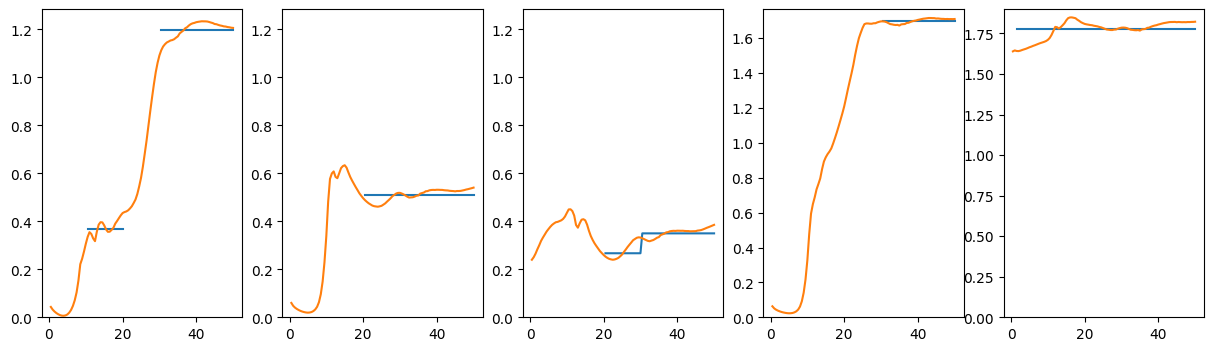

In [3]:
data_dir = "/home/vturino/PhD/projects/exhumation/plots/single_models"
output_dir = "kinematic_mu0.13_basalt7.5km_sed1km_cttV"
files_dir = f"{data_dir}/{output_dir}/txt_files/stagnant"

part = [11580, 2241, 47, 9025, 41068]
fig, ax = plt.subplots(1, len(part), figsize=(15, 4))

maxdata = np.zeros(len(part))
maxplot = 1

particles = pd.DataFrame(columns=["id", "timePmax", "Pmax", "timeP1", "P1", "timeP2", "P2", "timeP3", "P3", "timeP4", "P4"], index=range(len(part)))

for p in range(len(part)):
    id = part[p]
    # Load the data
    data = pd.read_csv(f"{data_dir}/{output_dir}/txt_files/PT/pt_part_{id}.txt", sep="\s+")
    data["Plith"] = (901.e3 - data["y"])*3100*9.81/1e9
    data["time"] = data["time"]/2
    data["ts"] = data["time"]*2
    maxdata[p] = data["Plith"].max()


    tin = 0
    for i in range(len(data)):
        if (data.y.iloc[0] - data.y.iloc[i]) > 2.:
            tin = data.time.iloc[i]
            break

    # Bin data by time intervals of 10 Myr
    bins = np.arange(0, 51, 10)
    data["time_bin"] = pd.cut(data["time"], bins)

    data["Pdiff"] = data.groupby("time_bin")["Plith"].transform(lambda x: abs(x.max() - x.min()))
    data.loc[data["time"] <= tin, "Pdiff"] = np.nan
    data[data["Pdiff"] <= data["Plith"].max()/10]
    data["Pmaxloc"] = data.apply(lambda row: data[(data["time_bin"] == row["time_bin"]) & (data["Pdiff"] <= 0.15)]["Plith"].median() if pd.notna(row["Pdiff"]) and row["Pdiff"] <= 0.15 else np.nan, axis=1)

    # Step 1: Mark non-NaN Pmaxloc values
    data['Pmaxloc_not_nan'] = data['Pmaxloc'].notna()

    # Step 2: Create time_bin_consecutive
    data['time_bin_consecutive'] = np.where(
        data['Pmaxloc_not_nan'],
        (data['Pmaxloc_not_nan'] & (data['time_bin'] != data['time_bin'].shift())).cumsum(),
        np.nan
    )

    #if time_bin_consecutive is numeric and goes from value to value+1, use value instead of value+1
    for i in range(0, len(data)-1):
        if data["time_bin_consecutive"].iloc[i+1] > data["time_bin_consecutive"].iloc[i]:
            if abs(data["Pmaxloc"].iloc[i] - data["Pmaxloc"].iloc[i+1]) < data["Plith"].max()/10:
                data["time_bin_consecutive"].iloc[i+1] = data["time_bin_consecutive"].iloc[i]
    
    # calculate difference in Plith between first value of one time_bin_consecutive_new and the last value of the next time_bin_consecutive_new
    data['Pdiff_new'] = data.groupby('time_bin_consecutive')['Plith'].transform(lambda x: x.iloc[-1] - x.iloc[0])
    data['Pmaxloc_new'] = data.groupby('time_bin_consecutive')['Pmaxloc'].transform("mean")

    #save to particles dataframe
    particles["id"].iloc[p] = id
    particles["timePmax"].iloc[p] = data["time"][data["Plith"].idxmax()]
    particles["Pmax"].iloc[p] = data["Plith"].max()

    for k in range(len(data["Pmaxloc_new"].dropna().unique())): 
        particles[f"P{k+1}"].iloc[p] = data["Pmaxloc_new"].dropna().unique()[k]
        particles[f"timeP{k+1}"].iloc[p] = data[data["time_bin_consecutive"] == data["time_bin_consecutive"].dropna().unique()[k]]["time"].median()
    

    if maxdata[p] > maxplot:
        maxplot = maxdata[p]+0.05
    
    ax[p].plot(data["time"], data["Pmaxloc_new"])
    ax[p].plot(data["time"], data["Plith"])
    ax[p].set_ylim(0, maxplot)

particles = particles.astype(float)
particles["id"] = particles["id"].astype(int)
particles.to_csv(f"{data_dir}/{output_dir}/txt_files/stagnant_maxima.txt", sep="\t", index=False, header=True, float_format='%.2f')

    

    